# Portfolio Optimisation

The portfolio consists of FAANG with past 5 years historical data

# 1.0 Setup

## 1.1 Install library

Package required
- PyPortfolioOpt
- yfinance

In [1]:
# Uncomment to install required package
# !pip install PyPortfolioOpt
# !pip install yfinance

## 1.2 Import library

In [2]:
# System
import datetime as dt
from functools import partial

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

# Source
import yfinance as yf

# Port optimisation
from pypfopt.efficient_frontier import EfficientFrontier

# Optimisation
from scipy.optimize import minimize

## 1.3 Define parameter

In [3]:
beg_dt = dt.datetime(2017, 1, 1)
end_dt = dt.datetime(2022, 12, 31)

In [4]:
t_bill_ticker = '^TNX'  # 10 years
faang_tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']

In [5]:
SEED = 101
TRADING_DAYS = 252

PORT_WEIGHTS = (-1, 1)  # Able to LONG and SHORT but without leverage

## 1.4 Fetch dataset

In [6]:
fetch_data = partial(yf.download, start=beg_dt, end=end_dt)

In [7]:
faang = fetch_data(faang_tickers)
t_bill = fetch_data(t_bill_ticker)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


# 2.0 Overview

## 2.1 US 10 Years Treasury Bills

In [8]:
t_bill.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,2.511,2.518,2.448,2.450,2.450,0
2017-01-04 00:00:00-05:00,2.456,2.474,2.434,2.452,2.452,0
2017-01-05 00:00:00-05:00,2.439,2.443,2.346,2.368,2.368,0
2017-01-06 00:00:00-05:00,2.339,2.425,2.339,2.418,2.418,0
2017-01-09 00:00:00-05:00,2.387,2.392,2.368,2.376,2.376,0


In [9]:
t_bill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1510 non-null   float64
 1   High       1510 non-null   float64
 2   Low        1510 non-null   float64
 3   Close      1510 non-null   float64
 4   Adj Close  1510 non-null   float64
 5   Volume     1510 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.6 KB


In [10]:
t_bill.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1510.0,2.106733,0.840254,0.484,1.52900,2.2215,2.78675,4.331
High,1510.0,2.132493,0.843088,0.538,1.55500,2.2430,2.81875,4.333
Low,1510.0,2.081556,0.837063,0.398,1.50525,2.2095,2.75375,4.200
Close,1510.0,2.107679,0.839999,0.499,1.52725,2.2195,2.78775,4.234
Adj Close,1510.0,2.107679,0.839999,0.499,1.52725,2.2195,2.78775,4.234
Volume,1510.0,0.000000,0.000000,0.000,0.00000,0.0000,0.00000,0.000


## 2.2 FAANG

In [11]:
faang.head()

Adj Close                                    \
                                AAPL       AMZN       GOOG        META   
Date                                                                     
2017-01-03 00:00:00-05:00  27.174755  37.683498  39.306999  116.860001   
2017-01-04 00:00:00-05:00  27.144337  37.859001  39.345001  118.690002   
2017-01-05 00:00:00-05:00  27.282375  39.022499  39.701000  120.669998   
2017-01-06 00:00:00-05:00  27.586529  39.799500  40.307499  123.410004   
2017-01-09 00:00:00-05:00  27.839205  39.846001  40.332500  124.900002   

                                           Close                        \
                                 NFLX       AAPL       AMZN       GOOG   
Date                                                                     
2017-01-03 00:00:00-05:00  127.489998  29.037500  37.683498  39.306999   
2017-01-04 00:00:00-05:00  129.410004  29.004999  37.859001  39.345001   
2017-01-05 00:00:00-05:00  131.809998  29.152500  39.022499  39.701000   
2017-01-06 00:00:00-05:00  131.070007  29.477501  39.799500  40.307499   
2017-01-09 00:00:00-05:00  130.949997  29.747499  39.846001  40.332500   

                                                   ...       Open             \
                                 META        NFLX  ...       AAPL       AMZN   
Date                                               ...                         
2017-01-03 00:00:00-05:00  116.860001  127.489998  ...  28.950001  37.896000   
2017-01-04 00:00:00-05:00  118.690002  129.410004  ...  28.962500  37.919498   
2017-01-05 00:00:00-05:00  120.669998  131.809998  ...  28.980000  38.077499   
2017-01-06 00:00:00-05:00  123.410004  131.070007  ...  29.195000  39.118000   
2017-01-09 00:00:00-05:00  124.900002  130.949997  ...  29.487499  39.900002   

                                                                 Volume  \
                                GOOG        META        NFLX       AAPL   
Date                                                                      
2017-01-03 00:00:00-05:00  38.940498  116.029999  124.959999  115127600   
2017-01-04 00:00:00-05:00  39.417999  117.550003  127.489998   84472400   
2017-01-05 00:00:00-05:00  39.304001  118.860001  129.220001   88774400   
2017-01-06 00:00:00-05:00  39.763000  120.980003  132.080002  127007600   
2017-01-09 00:00:00-05:00  40.320000  123.550003  131.479996  134247600   

                                                                    
                                AMZN      GOOG      META      NFLX  
Date                                                                
2017-01-03 00:00:00-05:00   70422000  33146000  20663900   9437900  
2017-01-04 00:00:00-05:00   50210000  21460000  19630900   7843600  
2017-01-05 00:00:00-05:00  116602000  26704000  19492200  10185500  
2017-01-06 00:00:00-05:00  119724000  32804000  28545300  10657900  
2017-01-09 00:00:00-05:00   68922000  25492000  22880400   5771800  

[5 rows x 30 columns]

In [12]:
faang.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  1510 non-null   float64
 1   (Adj Close, AMZN)  1510 non-null   float64
 2   (Adj Close, GOOG)  1510 non-null   float64
 3   (Adj Close, META)  1510 non-null   float64
 4   (Adj Close, NFLX)  1510 non-null   float64
 5   (Close, AAPL)      1510 non-null   float64
 6   (Close, AMZN)      1510 non-null   float64
 7   (Close, GOOG)      1510 non-null   float64
 8   (Close, META)      1510 non-null   float64
 9   (Close, NFLX)      1510 non-null   float64
 10  (High, AAPL)       1510 non-null   float64
 11  (High, AMZN)       1510 non-null   float64
 12  (High, GOOG)       1510 non-null   float64
 13  (High, META)       1510 non-null   float64
 14  (High, NFLX)       1510 non-null   float64
 15  (Low, AAPL)        1510 

In [13]:
faang.describe().T

count          mean           std           min  \
Adj Close AAPL  1510.0  8.663047e+01  4.836396e+01  2.714434e+01   
          AMZN  1510.0  1.079432e+02  4.204619e+01  3.768350e+01   
          GOOG  1510.0  7.933788e+01  3.220056e+01  3.930700e+01   
          META  1510.0  2.076986e+02  6.560591e+01  8.891000e+01   
          NFLX  1510.0  3.507876e+02  1.371645e+02  1.274900e+02   
Close     AAPL  1510.0  8.804373e+01  4.792671e+01  2.900500e+01   
          AMZN  1510.0  1.079432e+02  4.204619e+01  3.768350e+01   
          GOOG  1510.0  7.933788e+01  3.220056e+01  3.930700e+01   
          META  1510.0  2.076986e+02  6.560591e+01  8.891000e+01   
          NFLX  1510.0  3.507876e+02  1.371645e+02  1.274900e+02   
High      AAPL  1510.0  8.901718e+01  4.855790e+01  2.908250e+01   
          AMZN  1510.0  1.092636e+02  4.264665e+01  3.793800e+01   
          GOOG  1510.0  8.016242e+01  3.259265e+01  3.948150e+01   
          META  1510.0  2.103353e+02  6.636906e+01  9.046000e+01   
          NFLX  1510.0  3.561977e+02  1.389121e+02  1.281900e+02   
Low       AAPL  1510.0  8.698951e+01  4.726004e+01  2.869000e+01   
          AMZN  1510.0  1.066075e+02  4.151467e+01  3.738500e+01   
          GOOG  1510.0  7.848969e+01  3.184174e+01  3.879000e+01   
          META  1510.0  2.049880e+02  6.484727e+01  8.809000e+01   
          NFLX  1510.0  3.450848e+02  1.355469e+02  1.243100e+02   
Open      AAPL  1510.0  8.798563e+01  4.791450e+01  2.895000e+01   
          AMZN  1510.0  1.080132e+02  4.210978e+01  3.789600e+01   
          GOOG  1510.0  7.930604e+01  3.222930e+01  3.894050e+01   
          META  1510.0  2.076290e+02  6.562373e+01  9.008000e+01   
          NFLX  1510.0  3.507927e+02  1.373782e+02  1.249600e+02   
Volume    AAPL  1510.0  1.154938e+08  5.360440e+07  3.519590e+07   
          AMZN  1510.0  8.385988e+07  4.012741e+07  1.762600e+07   
          GOOG  1510.0  3.073554e+07  1.338656e+07  6.936000e+06   
          META  1510.0  2.291348e+07  1.591338e+07  6.046300e+06   
          NFLX  1510.0  7.936315e+06  6.512317e+06  1.144000e+06   

                         25%           50%           75%           max  
Adj Close AAPL  4.216168e+01  6.539593e+01  1.348019e+02  1.809597e+02  
          AMZN  8.039812e+01  9.514275e+01  1.544710e+02  1.865705e+02  
          GOOG  5.415763e+01  6.476550e+01  1.047664e+02  1.507090e+02  
          META  1.641425e+02  1.854500e+02  2.490950e+02  3.821800e+02  
          NFLX  2.402825e+02  3.426350e+02  4.805850e+02  6.916900e+02  
Close     AAPL  4.398938e+01  6.675250e+01  1.353850e+02  1.820100e+02  
          AMZN  8.039812e+01  9.514275e+01  1.544710e+02  1.865705e+02  
          GOOG  5.415763e+01  6.476550e+01  1.047664e+02  1.507090e+02  
          META  1.641425e+02  1.854500e+02  2.490950e+02  3.821800e+02  
          NFLX  2.402825e+02  3.426350e+02  4.805850e+02  6.916900e+02  
High      AAPL  4.434688e+01  6.750875e+01  1.372650e+02  1.829400e+02  
          AMZN  8.120688e+01  9.627375e+01  1.566306e+02  1.886540e+02  
          GOOG  5.472744e+01  6.525325e+01  1.057410e+02  1.521000e+02  
          META  1.662050e+02  1.871850e+02  2.526675e+02  3.843300e+02  
          NFLX  2.453875e+02  3.489250e+02  4.877125e+02  7.009900e+02  
Low       AAPL  4.363000e+01  6.596000e+01  1.337600e+02  1.791200e+02  
          AMZN  7.955838e+01  9.434400e+01  1.518515e+02  1.848395e+02  
          GOOG  5.361069e+01  6.408750e+01  1.032711e+02  1.498875e+02  
          META  1.615625e+02  1.834450e+02  2.463625e+02  3.788100e+02  
          NFLX  2.337375e+02  3.375300e+02  4.743025e+02  6.860900e+02  
Open      AAPL  4.387062e+01  6.669250e+01  1.358125e+02  1.826300e+02  
          AMZN  8.025638e+01  9.542350e+01  1.548934e+02  1.872000e+02  
          GOOG  5.417900e+01  6.467400e+01  1.041749e+02  1.518635e+02  
          META  1.639100e+02  1.850300e+02  2.487550e+02  3.816800e+02  
          NFLX  2.391625e+02  3.431050e+02  4.800900e+02  6.923500e+02  
Volume    

# 3.0 Calculation

## 3.1 Combine adjusted close for FAANG and T-Bill

In [14]:
adj_close = faang['Adj Close']

In [15]:
adj_close.head()

,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2017-01-03 00:00:00-05:00,27.174755,37.683498,39.306999,116.860001,127.489998
2017-01-04 00:00:00-05:00,27.144337,37.859001,39.345001,118.690002,129.410004
2017-01-05 00:00:00-05:00,27.282375,39.022499,39.701000,120.669998,131.809998
2017-01-06 00:00:00-05:00,27.586529,39.799500,40.307499,123.410004,131.070007
2017-01-09 00:00:00-05:00,27.839205,39.846001,40.332500,124.900002,130.949997


## 3.2 Historical Performance

In [16]:
normalised_adj_close = adj_close / adj_close.iloc[0]

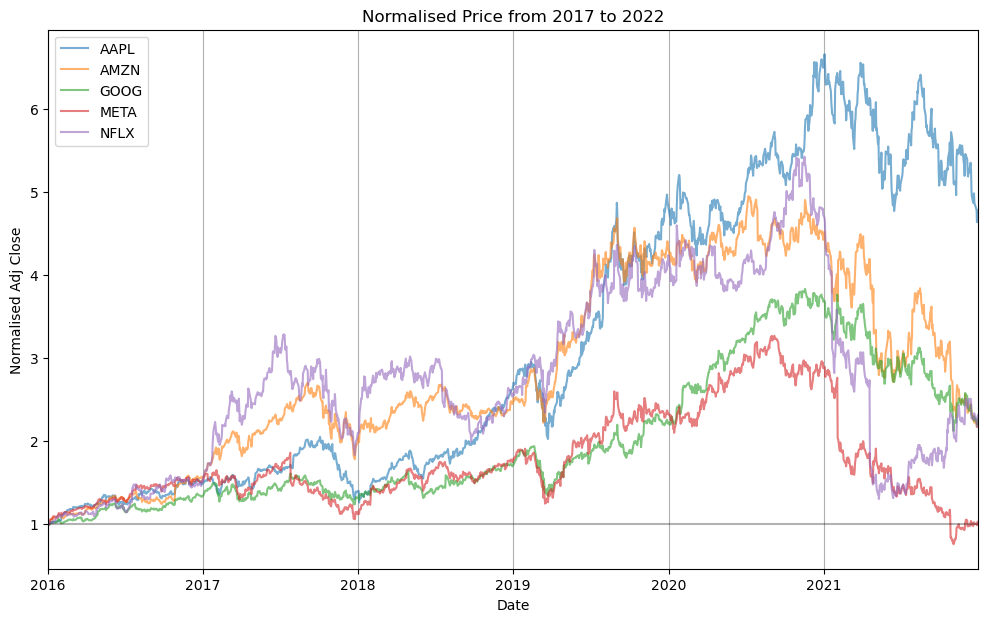

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(normalised_adj_close, alpha=0.6, label=normalised_adj_close.columns)
ax.axhline(1.0, alpha=0.3, c='black')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.grid(True)

ax.set_xlabel('Date')
ax.set_xlim([beg_dt, end_dt])
ax.set_ylabel('Normalised Adj Close')
ax.set_title('Normalised Price from 2017 to 2022')

plt.legend()

plt.show()

## 3.3 Calculate expected return

In [18]:
port_daily_ret = adj_close.pct_change()
port_daily_ret = port_daily_ret.dropna()

In [19]:
port_ret = port_daily_ret.mean() * TRADING_DAYS

port_ret.sort_values(ascending=False)

AAPL    0.310760
NFLX    0.244965
AMZN    0.190907
GOOG    0.178981
META    0.087812
dtype: float64

Apple (AAPL) has the highest annual return, 31.08%

## 3.4 Calculate volatility

In [20]:
port_risk = (port_daily_ret.var() * TRADING_DAYS) ** 0.5

port_risk.sort_values(ascending=False)

NFLX    0.450700
META    0.400963
AMZN    0.337989
AAPL    0.314095
GOOG    0.293116
dtype: float64

Netflix (NFLX) has the highest volatility, 45.07%

## 3.5 Calculate risk-free rate

In [21]:
rfr = t_bill['Adj Close'].mean() / 100

rfr

0.021076788061896695

The risk-free rate of US 10 years treasury bills is 2.11%

## 3.6 Calculate portfolio covariance

In [22]:
port_cov = port_daily_ret.cov() * TRADING_DAYS

port_cov

,AAPL,AMZN,GOOG,META,NFLX
AAPL,0.098655,0.068342,0.063533,0.073333,0.067283
AMZN,0.068342,0.114236,0.067841,0.082786,0.091453
GOOG,0.063533,0.067841,0.085917,0.079397,0.068527
META,0.073333,0.082786,0.079397,0.160771,0.094679
NFLX,0.067283,0.091453,0.068527,0.094679,0.203131


# 4.0 Portfolio

In [23]:
efficient_frontier = partial(EfficientFrontier, port_ret, port_cov, PORT_WEIGHTS)

Portfolio return

$$ r_p = w_1 r_1 + w_2r_2 + \cdots + w_nr_n $$

In [24]:
def calc_port_ret(weights: np.array):
    return np.dot(port_ret.T, weights)

Portfolio risk

$$ \sigma^2_p = \sum^n_{i=1} \sum^n_{j=1} w_i w_j Cov(r_i, r_j) $$

In [25]:
def calc_port_risk(weights: np.array):
    cov = np.dot(port_cov, weights)
    port_var = np.dot(weights.T, cov)
    port_vol = np.sqrt(port_var)

    return port_vol

## 4.1 Simulate Portfolio

In [26]:
n_sim = 1_000
n_ticker = len(faang_tickers)

Simulate random weights between -1 and 1 (i.e. allows LONG and SHORT)

In [27]:
# TODO sum
np.random.seed(42)

rand_weights = np.random.random(size=(n_sim, n_ticker))
rand_weights = rand_weights - 0.5  # shift the random number to (0.5, 0.5]

sum_weights = np.sum(rand_weights, axis=1)
sim_weights = rand_weights / sum_weights[:, None]

In [28]:
sim_weights = pd.DataFrame(sim_weights,
                           columns=[f'w{i + 1}' for i in range(sim_weights.shape[-1])])

sim_weights

,w1,w2,w3,w4,w5
0,-0.402211,1.444942,0.743748,0.316289,-1.102768
1,3.111535,3.997141,-3.312069,-0.914587,-1.882020
2,1.694653,-1.661052,-1.175129,1.016833,1.124695
3,0.414163,0.256086,-0.032386,0.089028,0.273109
4,-0.176403,0.568553,0.327808,0.210760,0.069282
...,...,...,...,...,...
995,0.031642,0.223653,0.174634,0.296416,0.273655
996,0.617677,-0.333433,0.211348,0.438846,0.065562
997,-0.718857,0.472771,0.207771,0.479266,0.559049
998,4.421598,0.684182,-1.472832,1.380808,-4.013757


Calculate simulated portfolio return

In [29]:
sim_port_ret = sim_weights.apply(calc_port_ret, axis=1)

sim_port_ret

0      0.041610
1      0.595885
2      0.363998
3      0.246517
4      0.147872
         ...   
995    0.176851
996    0.220718
997    0.083084
998    0.379082
999    0.277801
Length: 1000, dtype: float64

Calculate simulated portfolio risk

In [30]:
sim_port_risk = sim_weights.apply(calc_port_risk, axis=1)

sim_port_risk

0      0.526894
1      1.282817
2      0.707750
3      0.304511
4      0.313646
         ...   
995    0.315564
996    0.322402
997    0.438464
998    1.672162
999    0.600903
Length: 1000, dtype: float64

Calculate sharpe ratio

In [31]:
sim_port_sharpe = (sim_port_ret - rfr) / sim_port_risk

sim_port_sharpe

0      0.038970
1      0.448083
2      0.484523
3      0.740336
4      0.404264
         ...   
995    0.493637
996    0.619229
997    0.141418
998    0.214097
999    0.427232
Length: 1000, dtype: float64

## 4.2 Efficient Frontier

In [32]:
ef_ret_range = np.linspace(-0.3, 0.5, 100)

In [33]:
bounds = tuple((-1, 1) for n in range(n_ticker))
eq_weights = n_ticker * [1 / n_ticker]

ef_constraints = (
    {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    },
    {
        'type': 'eq',
        'fun': lambda weights: np.dot(np.array(weights), port_ret.T) - target_return
    }
)

In [34]:
ef_risk = []

for target_return in ef_ret_range:
    result = minimize(calc_port_risk,
                      x0=eq_weights,
                      bounds=bounds,
                      constraints=ef_constraints)

    ef_risk.append(result.fun)

## 4.3 Max Sharpe Ratio

In [35]:
opt_port = efficient_frontier()
opt_port.max_sharpe()

opt_port_ret, opt_port_vol, opt_port_sharpe = opt_port.portfolio_performance()
opt_weights = opt_port.clean_weights()

In [36]:
print('--- Max Sharpe Ratio ---')
print(f'Portfolio return: {opt_port_ret * 100:.2f}%')
print(f'Portfolio risk: {opt_port_vol * 100:.2f}%')
print(f'Portfolio sharpe ratio: {opt_port_sharpe:.2f}')
print('Weights =>', end=' ')
print(opt_weights)

--- Max Sharpe Ratio ---
Portfolio return: 37.49%
Portfolio risk: 33.93%
Portfolio sharpe ratio: 1.05
Weights => OrderedDict([('AAPL', 1.0), ('AMZN', 0.02044), ('GOOG', 0.29052), ('META', -0.53709), ('NFLX', 0.22612)])


## 4.4 Minimum Variance

In [37]:
min_var_port = efficient_frontier()
min_var_port.min_volatility()

min_var_port_ret, min_var_port_vol, min_var_port_sharpe = min_var_port.portfolio_performance()
min_var_weights = min_var_port.clean_weights()

In [38]:
print('--- Minimum Variance ---')
print(f'Portfolio return: {min_var_port_ret * 100:.2f}%')
print(f'Portfolio risk: {min_var_port_vol * 100:.2f}%')
print(f'Portfolio sharpe ratio: {min_var_port_sharpe:.2f}')
print('Weights =>', end=' ')
print(min_var_weights)

--- Minimum Variance ---
Portfolio return: 22.94%
Portfolio risk: 27.47%
Portfolio sharpe ratio: 0.76
Weights => OrderedDict([('AAPL', 0.32517), ('AMZN', 0.1548), ('GOOG', 0.52178), ('META', -0.03717), ('NFLX', 0.03542)])


## 4.5 Capital Market Line

In [39]:
cml_slope = (opt_port_ret - rfr) / (opt_port_vol - 0)

In [40]:
cml_x = np.linspace(0, 0.6, 6)
cml_y = cml_slope * cml_x + rfr

cml_x, cml_y

(array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 ]),
 array([0.02107679, 0.146198  , 0.27131921, 0.39644041, 0.52156162,
        0.64668283]))

## 4.5 Plot Portfolio

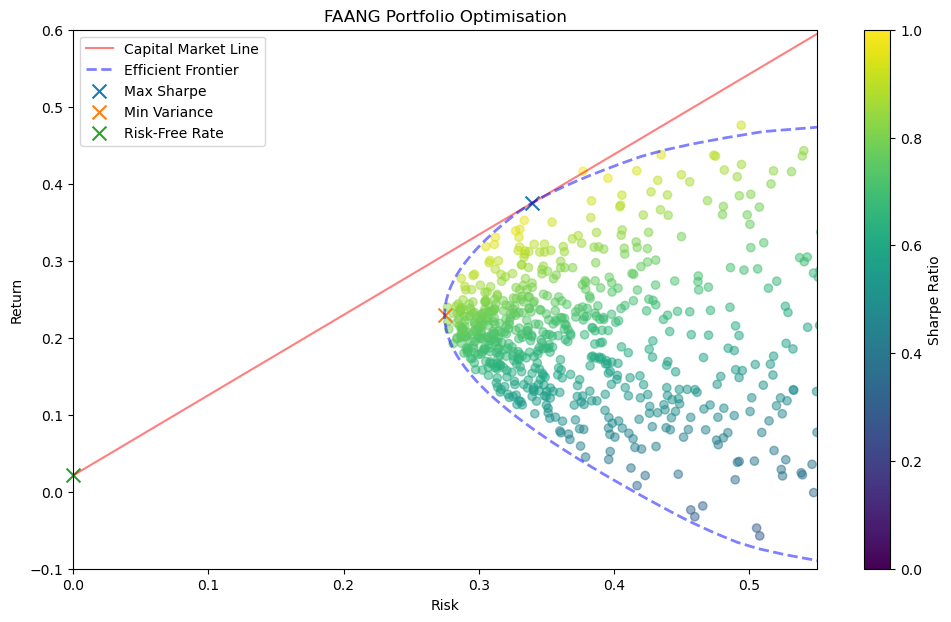

In [41]:
fig, ax = plt.subplots(figsize=(12, 7))

# Simulated different portfolio
ax.scatter(sim_port_risk, sim_port_ret, c=sim_port_sharpe, alpha=0.5)
fig.colorbar(mappable=None, label='Sharpe Ratio', ax=plt.gca())

ax.plot(cml_x, cml_y, 'r', alpha=0.5, label='Capital Market Line')
ax.plot(ef_risk, ef_ret_range, 'b--', linewidth=2, alpha=0.5, label='Efficient Frontier')
ax.scatter(opt_port_vol, opt_port_ret, marker='x', s=100, label='Max Sharpe')
ax.scatter(min_var_port_vol, min_var_port_ret, marker='x', s=100, clip_on=False, label='Min Variance')
ax.scatter(0, rfr, marker='x', s=100, clip_on=False, label='Risk-Free Rate')

# Plot config
ax.set_xlim(0, 0.55)
ax.set_ylim(-0.1, 0.6)

ax.set_xlabel('Risk')
ax.set_ylabel('Return')
ax.set_title('FAANG Portfolio Optimisation')

plt.legend()

plt.show()

# 5.0 Conclusion

In summary, an optimal portfolio has been generated with FAANG stock.

The risk-free rate is 2.11%. (based on US 10-years treasury bill)

The portfolio with the highest Sharpe ratio is the optimal portfolio which has a portfolio return, 37.49%
and portfolio risk: 33.93%. The weightage for FAANG portfolio as follows:

| **Ticker** | **Weightage** |
|:----------:|:-------------:|
|    AAPL    |      1.00     |
|    AMZN    |      0.02     |
|    GOOG    |      0.29     |
|    META    |     -0.54     |
|    NFLX    |      0.23     |

Risk-adverse investor can pick the lowest risk of FAANG portfolio which has a portfolio return, 22.94% and
portfolio risk, 27.47%. The weightage for FAANG portfolio as follows:

| **Ticker** | **Weightage** |
|:----------:|:-------------:|
|    AAPL    |      0.33     |
|    AMZN    |      0.15     |
|    GOOG    |      0.52     |
|    META    |     -0.04     |
|    NFLX    |      0.04     |


For different risk-appetite, they can choose their risk first and their corresponding optimal return will lies on the efficient frontier.